# Preprocessing and Feature Engineering

## Preprocessing


### Imports


In [1]:
# Imports
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

### Load the Data

Load the data that has already been split in the EDA.
Perform the following checks:

- Shape - ensures that the inputs (features - X) and outputs (labels - y) have the same number of samples
- Check for missing values
- Check for duplicates


In [ ]:
# Folder path
path = Path("../data/split")

# Load data (already split)
X_train = pd.read_csv(path / "X_train.csv")
X_test = pd.read_csv(path / "X_test.csv")
y_train = pd.read_csv(path / "y_train.csv")
y_test = pd.read_csv(path / "y_test.csv")

# Drop the unwanted index-like column
if "Unnamed: 0" in X_train.columns:
    X_train = X_train.drop(columns=["Unnamed: 0"])
if "Unnamed: 0" in X_test.columns:
    X_test = X_test.drop(columns=["Unnamed: 0"])
if "Unnamed: 0" in y_train.columns:
    y_train = y_train["Diagnosis"]
if "Unnamed: 0" in y_test.columns:
    y_test = y_test["Diagnosis"]

# Quick checks
# Shape
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

# Missing values
print("Missing values")
print(X_train.isna().sum().sum(), X_test.isna().sum().sum())
print(y_train.isna().sum(), y_test.isna().sum())

# Duplicated rows in X (optional)
print("Duplicates")
print(X_train.duplicated().sum(), X_test.duplicated().sum())

X train: (1934, 32)
y train: (1934,)
X test: (215, 32)
y test: (215,)
Missing values
0 0
0 0
Duplicates
0 0


### Preprocessing Pipeline

This section preprocesses the data by:

- Imputing missing samples (Since the EDA found that there were no missing, duplicate or outlier entries, it is not necessary to include the handling of these in the preprocessing, however we still include an imputer for the case where other data which has missing values is used.)
- Scaling numerical features to improve numerical stability
- Encode categorical features with one-hot vectors


In [ ]:
# Get numeric and categorical features (from EDA)
numeric_cols = [
    "Age",
    "BMI",
    "AlcoholConsumption",
    "PhysicalActivity",
    "DietQuality",
    "SleepQuality",
    "SystolicBP",
    "DiastolicBP",
    "CholesterolTotal",
    "CholesterolLDL",
    "CholesterolHDL",
    "CholesterolTriglycerides",
    "MMSE",
    "FunctionalAssessment",
    "ADL",
]

categorical_cols = [
    "Gender",
    "Ethnicity",
    "EducationLevel",
    "Smoking",
    "FamilyHistoryAlzheimers",
    "CardiovascularDisease",
    "Diabetes",
    "Depression",
    "HeadInjury",
    "Hypertension",
    "MemoryComplaints",
    "BehavioralProblems",
    "Confusion",
    "Disorientation",
    "PersonalityChanges",
    "DifficultyCompletingTasks",
    "Forgetfulness",
]

# Preprocessing pipeline - impute, scale and encode
numeric_transformer = Pipeline(
    steps=[
        # Handles missing values
        ("imputer", SimpleImputer(strategy="median")),
        # Improves numerical stability
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        # Handles missing values
        ("imputer", SimpleImputer(strategy="most_frequent")),
        # Encodes categorical features to onehot vectors
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

## Feature Engineering

### Feature Selection

#### ANOVA F-test and Mutual Information selector

- The ANOVA F-test selects features that maximise between-class variability while minimising within-class variability.
- The MI selector chooses eliminates features with high mutual information (similar input) to other features


In [ ]:
# Number of features
# Design choice - High enough to include sufficient information but low enough to maintain interpretability
k = 12

# ANOVA F-test
anova_selector = SelectKBest(score_func=f_classif, k=k)

anova_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("select_anova", anova_selector),
    ]
)

# MI selector
mi_selector = SelectKBest(
    score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k=k
)

mi_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("select_mi", mi_selector),
    ]
)

In [ ]:
# ANOVA F-test
# Fit on training data
anova_pipeline.fit(X_train, y_train)

# Transform X to its selected-feature representation
X_train_anova = anova_pipeline.transform(X_train)
X_test_anova = anova_pipeline.transform(X_test)

print(X_train_anova.shape)  # (n_samples, k)

# MI
# Fit on training data
mi_pipeline.fit(X_train, y_train)

# Transform X to top-k MI features
X_train_mi = mi_pipeline.transform(X_train)
X_test_mi = mi_pipeline.transform(X_test)

print(X_train_mi.shape)  # (n_samples, k)

(1934, 12)
(1934, 12)


In [ ]:
# ANOVA
preprocess_anova = anova_pipeline.named_steps["preprocess"]
selector_anova = anova_pipeline.named_steps["select_anova"]

all_feature_names = preprocess_anova.get_feature_names_out()
anova_mask = selector_anova.get_support()
anova_features = all_feature_names[anova_mask]

# MI
preprocess_mi = mi_pipeline.named_steps["preprocess"]
selector_mi = mi_pipeline.named_steps["select_mi"]

mi_feature_names = (
    preprocess_mi.get_feature_names_out()
)  # same as all_feature_names if same preprocess
mi_mask = selector_mi.get_support()
mi_features = mi_feature_names[mi_mask]

print(f"ANOVA features:\n{anova_features}")
print(f"MI features:\n{mi_features}")

# Overlap and Difference
common = set(anova_features).intersection(set(mi_features))
print(f"{len(common)} Common features (ANOVA ∩ MI):\n{common}")

anova_excl_common = set(anova_features).difference(common)
print(
    f"{len(anova_excl_common)} Anova excl Common features (ANOVA - COMMON):\n{anova_excl_common}"
)

mi_excl_common = set(mi_features).difference(common)
print(f"{len(mi_excl_common)} MI excl Common features (MI - COMMON):\n{mi_excl_common}")

union_features = set(anova_features) | set(mi_features)
print(f"{len(union_features)} Common features (ANOVA ∩ MI):\n{union_features}")

ANOVA features:
['num__SleepQuality' 'num__CholesterolHDL' 'num__MMSE'
 'num__FunctionalAssessment' 'num__ADL' 'cat__Ethnicity_2'
 'cat__EducationLevel_0' 'cat__Diabetes_0' 'cat__MemoryComplaints_0'
 'cat__MemoryComplaints_1' 'cat__BehavioralProblems_0'
 'cat__BehavioralProblems_1']
MI features:
['num__AlcoholConsumption' 'num__SleepQuality' 'num__SystolicBP'
 'num__CholesterolHDL' 'num__MMSE' 'num__FunctionalAssessment' 'num__ADL'
 'cat__Ethnicity_2' 'cat__EducationLevel_0' 'cat__MemoryComplaints_0'
 'cat__MemoryComplaints_1' 'cat__BehavioralProblems_0']
10 Common features (ANOVA ∩ MI):
{'cat__EducationLevel_0', 'cat__BehavioralProblems_0', 'num__CholesterolHDL', 'cat__MemoryComplaints_0', 'cat__Ethnicity_2', 'num__SleepQuality', 'num__MMSE', 'cat__MemoryComplaints_1', 'num__ADL', 'num__FunctionalAssessment'}
2 Anova excl Common features (ANOVA - COMMON):
{'cat__BehavioralProblems_1', 'cat__Diabetes_0'}
2 MI excl Common features (MI - COMMON):
{'num__SystolicBP', 'num__AlcoholConsumpt

#### Correlation

We check for redundant features in the union of Anova and MI features using correlation. This can only be done for numerical features.


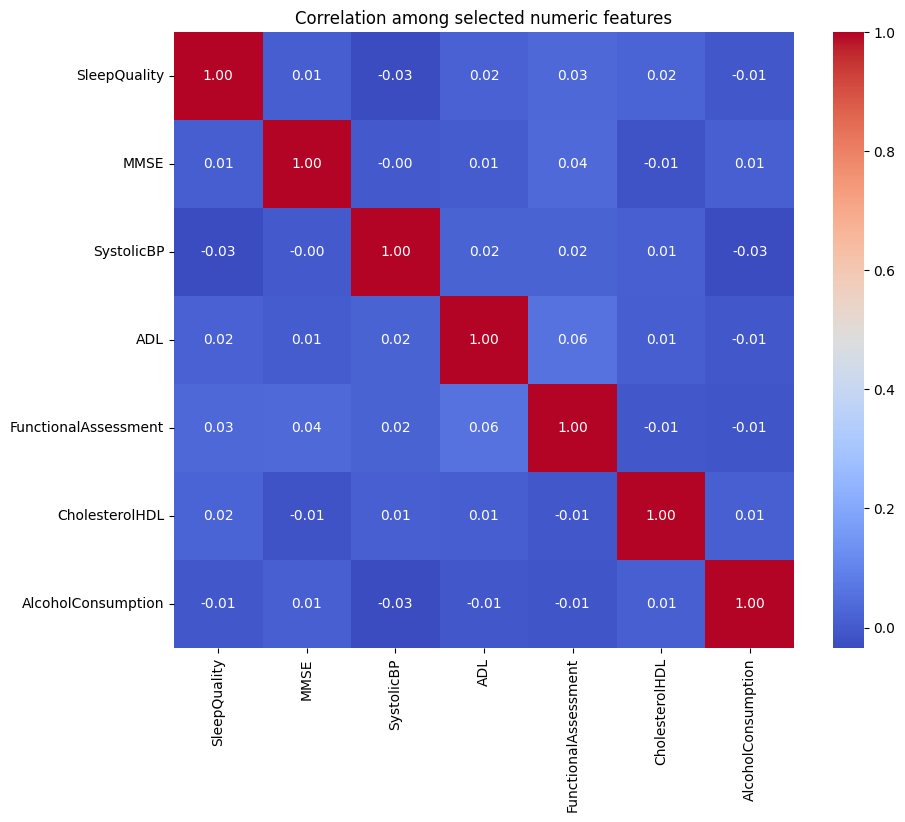

In [ ]:
# Check selected features for redundancy with correlation
selected_numeric = [
    f.replace("num__", "") for f in union_features if f.startswith("num__")
]

corr = X_train[selected_numeric].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation among selected numeric features")
plt.show()

#### Final Selector

We find very low correlation, a good indication. So we proceed with the union of the MI and Anova features.

This section applies the preprocessing to the training and test data, and then also selects these key features.


In [ ]:
# Fit preprocess only on X_train
preprocess_fitted = preprocess.fit(X_train)

# Transform train and test with the fitted preprocessing
X_train_pre = preprocess_fitted.transform(X_train)
X_test_pre = preprocess_fitted.transform(X_test)

# Get feature names after preprocessing (num__ / cat__ prefixes)
all_feature_names = preprocess_fitted.get_feature_names_out()

# Wrap in DataFrames for easier column selection
X_train_pre_df = pd.DataFrame(X_train_pre, columns=all_feature_names)
X_test_pre_df = pd.DataFrame(X_test_pre, columns=all_feature_names)

# Select the key features
selected_features = sorted(union_features)

X_train_sel = X_train_pre_df[selected_features]
X_test_sel = X_test_pre_df[selected_features]

print(X_train_sel.shape, X_test_sel.shape)

(1934, 14) (215, 14)


#### Save Selected Features


In [ ]:
out_path = Path("../data/selected")
out_path.mkdir(parents=True, exist_ok=True)

X_train_sel.to_csv(out_path / "X_train_selected.csv", index=False)
X_test_sel.to_csv(out_path / "X_test_selected.csv", index=False)

# labels can just be reused as-is
y_train.to_csv(out_path / "y_train.csv", index=False)
y_test.to_csv(out_path / "y_test.csv", index=False)

Function to get feature names without prefixes or suffixes for reporting


In [ ]:
# Clean feature names
def clean_name(name):
    if name.startswith("num__"):
        return name.replace("num__", "")
    if name.startswith("cat__"):
        base, _, level = name.replace("cat__", "").rpartition("_")
        return f"{base} = {level}"
    return name


cleaned = [clean_name(n) for n in selected_features]

print(cleaned)

['BehavioralProblems = 0', 'BehavioralProblems = 1', 'EducationLevel = 0', 'MemoryComplaints = 0', 'MemoryComplaints = 1', 'ADL', 'CholesterolHDL', 'FunctionalAssessment', 'MMSE', 'SleepQuality', 'SystolicBP']
